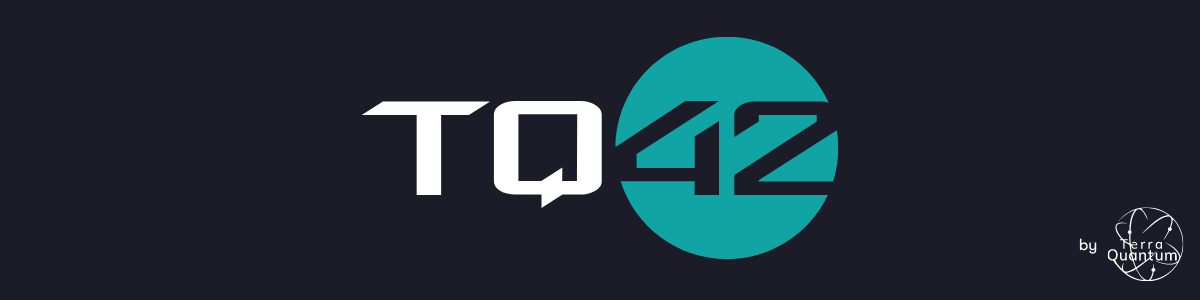

# Welcome to TQ42

## Example: Running a TetraOpt experiment using a communication channel

## ✨ Introduction 
A communication channel is a way for TetraOpt running in the cloud to communicate with an objective and local optimization function running locally. The example below will guide you in creating an experiment using this.

For further readings, you can also consult the [developer documentation](https://docs.tq42.com/en/latest/index.html).

## 🎯 Objective

Running a TetraOpt experiment involves:
1. Creating communication channels.
2. Creating an objective and local optimization fuction
3. Connecting the functions to the channels.


## 1. Import the TQ42 API

In [ ]:
#Import Packages
import asyncio
from scipy import optimize
from tq42.organization import list_all as list_all_organizations
from tq42.project import list_all as list_all_projects
from tq42.experiment import list_all as list_all_experiments
from tq42.channel import Channel, Ask, Tell
from tq42.client import TQ42Client
from tq42.algorithm import AlgorithmProto
import numpy as np
import OptimizationTestFunctions as otf

from tq42.experiment_run import ExperimentRun, HardwareProto
from ipywidgets import interact

## 2. Create a client

In [ ]:
# Connect to the cloud service
# https://terraquantum.io
with TQ42Client() as client:
    print(client)
    client.login()

## 3. Select an organization, project and experiment

In [ ]:
# List the organizations available to you and select one
org_list = list_all_organizations(client=client)
    
org=None
def f(x):
    global org
    for o in org_list:
        if o.data.name == x:
            org = o
            print(f"Using organization {x}, {org.data.id}")
            return
        
interact(f, x=[o.data.name for o in org_list]);
    

In [ ]:
proj_list = list_all_projects(client=client, organization_id=org.id)
    
proj=None
def f(x):
    global proj
    for p in proj_list:
        if p.data.name == x:
            proj = p
            print(f"Using project {x}, {proj.data.id}")
            return
        
interact(f, x=[p.data.name for p in proj_list]);
    

In [ ]:
# List the experiments within that project and select one
exp_list = list_all_experiments(client=client, project_id=proj.id)
    
exp=None
def f(x):
    global exp
    for e in exp_list:
        if e.data.name == x:
            exp = e
            print(f"Using experiment {x}, {exp.data.id}")
            return
        
interact(f, x=[e.data.name for e in exp_list]);

## 4. Create the communication channels

In [ ]:
objective_func_channel = await Channel.create(client=client)
local_opt_channel = await Channel.create(client=client)

print("objective_func_channel.id: ", objective_func_channel.id)
print("local_opt_channel.id: ", local_opt_channel.id)

## 5. Create an Objective Function

In [ ]:
#this needs to be declared async so it runs on a different thread
async def objective_function_callback(ask: Ask) -> Tell:
    dim = len(ask.headers)
    func = otf.Ackley(dim)
    y = [float(func(np.array(parameter.values))) for parameter in ask.parameters]
    
    tell = Tell(
        parameters=ask.parameters,
        headers=ask.headers,
        results=y
    )
    return tell

## 6. Create the local optimization function

In [ ]:
#this needs to be declared async so it runs on a different thread
async def local_optimization_function_callback(ask: Ask) -> Tell:
    dim = len(ask.headers)
    func = otf.Ackley(dim)
    results, new_x = [], []

    for parameter in ask.parameters:
        res = optimize.minimize(func, np.array(parameter.values))
        new_x.append({"values": res.x})
        results.append(float(res.fun))

    tell = Tell(
        parameters=ask.parameters,
        headers=ask.headers,
        results=results,
        candidates=new_x
    )
    return tell

## 7. Create the TetraOpt parameters 

In [ ]:
#For an explanation on each parameter, 
#you can refer to: https://docs.tq42.com/en/latest/TetraOpt_Algorithm/Parameters_and_Hyperparameters.html
tetra_opt_params = { 
    'dimensionality': 10,
    'iteration_number': 4, 
    'maximal_rank': 4, 
    'points_number': 1, 
    'quantization': False,
    'tolerance':0.001,
    'lower_limits': [0,0,0,0,0,0,0,0,0,0], 
    'upper_limits': [9,9,9,9,9,9,9,9,9,9], 
    'grid': [10,10,10,10,10,10,10,10,10,10],
    #for the 2 parameters below,
    #this is where we use the id of the channel object we created above
    "objective_function_channel_id": objective_func_channel.id,
    "local_optimizer_channel_id": local_opt_channel.id,
}



## 8. Create the experiment run

In [ ]:
run = ExperimentRun.create(
    client=client,
    algorithm=AlgorithmProto.TETRA_OPT,
    experiment_id=exp.id,
    compute=HardwareProto.SMALL,
    parameters={'parameters': tetra_opt_params, 'inputs': {}}
)

print(f"Running experiment within: \n Org ID {org.data.name, org.id}, \n Proj {proj.data.name, proj.id} and \n Exp {exp.data.name, exp.id}`")
print(f"Experiment run id: {run.id}")

## 9. Connect the callback functions to their respective channels

In [ ]:
#this needs to be declared async
await asyncio.gather(
        objective_func_channel.connect(
            callback=objective_function_callback,
            finish_callback=lambda: print("objective_function_callback async function done!"),
            max_duration_in_sec=None, message_timeout_in_sec=500
        ),
        local_opt_channel.connect(
            callback=local_optimization_function_callback,
            finish_callback=lambda: print("local_optimization_function_callback async function done!"),
            max_duration_in_sec=None, message_timeout_in_sec=500
        )
    )

## 10. Poll the result.

In [ ]:
#This will print out the result once it is ready.
print(run.poll())